CHIKAMADU SOPHIA OKORO





OKO22608981


images link: https://www.kaggle.com/datasets/volodymyrpivoshenko/brain-mri-scan-images-tumor-detection
 The image link contains two folders of MRI scan of positive and negative categories. Each folder was divided into train and test for effecient manupulation.

IMPORTATION OF NECESSARY LIBRARY

In [ ]:
#Installing torchinfo package
!pip install torchinfo

In [ ]:
!pip install scikit-plot

In [ ]:
# Standard libraries
import random
import os
import glob
import time
import warnings

# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Deep learning frameworks
import torch
import torchvision
import torch.optim.lr_scheduler as lr_scheduler
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchinfo import summary
from PIL import Image

# Progress tracking and typing
from tqdm.notebook import tqdm
from typing import Dict, List, Tuple

# Metrics and evaluation
from scikitplot.metrics import plot_roc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, precision_recall_fscore_support,
    accuracy_score, top_k_accuracy_score, f1_score,
    matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay
)


DEFINING DATA PATH

 Defining the dataset is essential for organizing, preparing, exploring, and ultimately providing the data needed for training and evaluating machine learning models

DATA EXPLORATION


This code sets up project configurations and retrieves information about the class structure (folders) within the training and testing directories, which is essential for organizing the data and defining the task

In [ ]:
import os
# Define a Python class CFG
class CFG:
    # Determine the device to be used for computations: 'cuda' if GPU is available, otherwise 'cpu'
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Get the number of available GPU devices
    num_devices = torch.cuda.device_count()

    # Get the number of CPU cores
    num_workers = os.cpu_count()

    # Define the number of classes in the classification task
    num_classes = 4

    # Define the number of epochs for training
    epochs = 10

    # Define the batch size for training data. If multiple GPUs are available, increase the batch size accordingly
    batch_size = (
        32 if torch.cuda.device_count() < 2
        else (32 * torch.cuda.device_count())
    )

    # Define the learning rate for the optimizer
    lr = 0.001

    # Specify whether to apply shuffle to the training data during each epoch
    apply_shuffle = True

    # Set a random seed for reproducibility
    seed = 768

    # Define the height and width of input images
    height = 224
    width = 224

    # Define the number of channels in input images (e.g., 3 for RGB images)
    channels = 3

    # Define the image size as a tuple (height, width, channels)
    image_size = (224, 224, 3)

    # Define paths
    dataset_path = '/content/drive/MyDrive/MRI_BRAIN_TUMOR'
    train_path = '/content/drive/MyDrive/MRI_BRAIN_TUMOR/Training'
    test_path = '/content/drive/MyDrive/MRI_BRAIN_TUMOR/Testing'

Establishing that all my images are in th jpg format

In [ ]:
import glob
# Define paths
train_images = glob.glob("/content/drive/MyDrive/MRI_BRAIN_TUMOR/Training/**/*.jpg", recursive=True)
test_images = glob.glob("/content/drive/MyDrive/MRI_BRAIN_TUMOR/Testing/**/*.jpg", recursive=True)

CREATING DATA FRAMES FOR EFFICIENT MANUPULATION


Typically this creates a structured representation of the image data that can be easily manipulated, analyzed, and used for tasks such as machine learning or data visualization.

MATTHEW JANSEN

PyTorch | Brain Tumor MRI Classification, Computer Program, Version 3 https://www.kaggle.com/code/matthewjansen/pytorch-brain-tumor-mri-classification/notebook#notebook-container

In [ ]:
# Build the DataFrames
train_df = build_df(train_images, generate_labels(train_images))
test_df = build_df(test_images, generate_labels(test_images))

# View first 5 samples in the dataset
train_df.head(5)

,image_path,label
0,/content/drive/MyDrive/MRI_BRAIN_TUMOR/Trainin...,Positive
1,/content/drive/MyDrive/MRI_BRAIN_TUMOR/Trainin...,Positive
2,/content/drive/MyDrive/MRI_BRAIN_TUMOR/Trainin...,Positive
3,/content/drive/MyDrive/MRI_BRAIN_TUMOR/Trainin...,Positive
4,/content/drive/MyDrive/MRI_BRAIN_TUMOR/Trainin...,Positive


In [ ]:
# Generating labels for image paths
def generate_labels(image_paths):
    return [(_.split('/')[-2:][0]).replace('-', '_') for _ in image_paths]


def build_df(image_paths, labels):
    # Create dataframe
    df = pd.DataFrame({
        'image_path': image_paths,
        'label': generate_labels(labels)
    })

    # Return dataframe
    return df

DATA VISUALIZATION

This section provides a convenient way to load image data from file paths and convert it into a tensor format, applying transformations such as converting to grayscale or resizing.

In [ ]:
# Loading  images using the Load function
def _load(image_path, as_tensor=True):
# Read and decode an image file to tensor
    image = Image.open(image_path)

    if as_tensor:
        converter = transforms.Compose([
            transforms.ToTensor(),
            transforms.Grayscale()
        ])
        return converter(image)
    else:
        return image

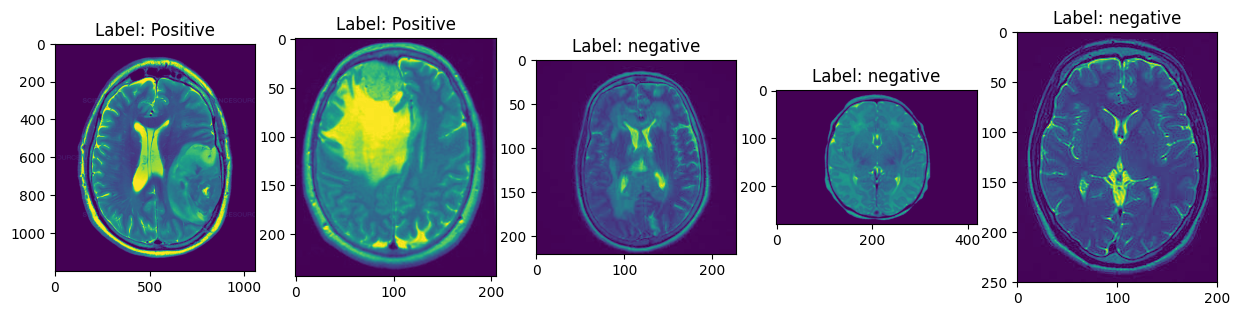

In [ ]:
# visualization of images
def view_mulitiple_samples(df, sample_loader, count=10, color_map='rgb', fig_size=(14, 10)):
    rows = count//5
    if count%5 > 0:
        rows +=1

    idx = random.sample(df.index.to_list(), count)
    fig = plt.figure(figsize=fig_size)

    for column, _ in enumerate(idx):
        plt.subplot(rows, 5, column+1)
        plt.title(f'Label: {df.label[_]}')

        if color_map=='rgb':
            plt.imshow(sample_loader(df.image_path[_]).permute(1, 2, 0))
        else:
            plt.imshow(sample_loader(df.image_path[_]).permute(1, 2, 0), cmap=color_map)

    return

# View 5 random images from the positive and negative folder
view_mulitiple_samples(
    train_df, _load,
    count=5, color_map='viridis',
    fig_size=(15, 15)
)

Train/validation split on the training dataset


This ensures that the training and validation sets are created with a specified proportion of the data while maintaining the distribution of classes across both sets.







In [ ]:
# Create Train/Val split with Training Set
train_split_idx, val_split_idx, _, _ = (
    train_test_split(
        train_df.index,
        train_df.label,
        test_size=0.20,
        stratify=train_df.label,
        random_state=CFG.seed
    )
)

In [ ]:
#Retrieves the training and validation datasets based on the indices obtained from the train/validation split
train_new_df = train_df.iloc[train_split_idx].reset_index(drop=True)
val_df = train_df.iloc[val_split_idx].reset_index(drop=True)

DATA PREPROCESSING


This is one for augmenting the training data and the other for preprocessing the test data

In [ ]:
# Augmentation of trained data
train_transforms = transforms.Compose([
    transforms.Resize((CFG.height, CFG.width)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
#     transforms.RandomRotation(degrees=30,),
    transforms.ToTensor()
])

# Only reshape test data
test_transforms = transforms.Compose([
    # Resizes the input image to the specified height and width.
    transforms.Resize((CFG.height, CFG.width)),
    #Converts the image to grayscale, ensuring it has three output channels (RGB format)
    transforms.Grayscale(num_output_channels=3),
    # Converts the image to a PyTorch tensor.
    transforms.ToTensor()
])

In [ ]:
# Select random sample from train_df
idx = random.sample(train_df.index.to_list(), 1)[0]

# Load the random sample and label
aug_image = _load(train_df.image_path[idx], as_tensor=False)

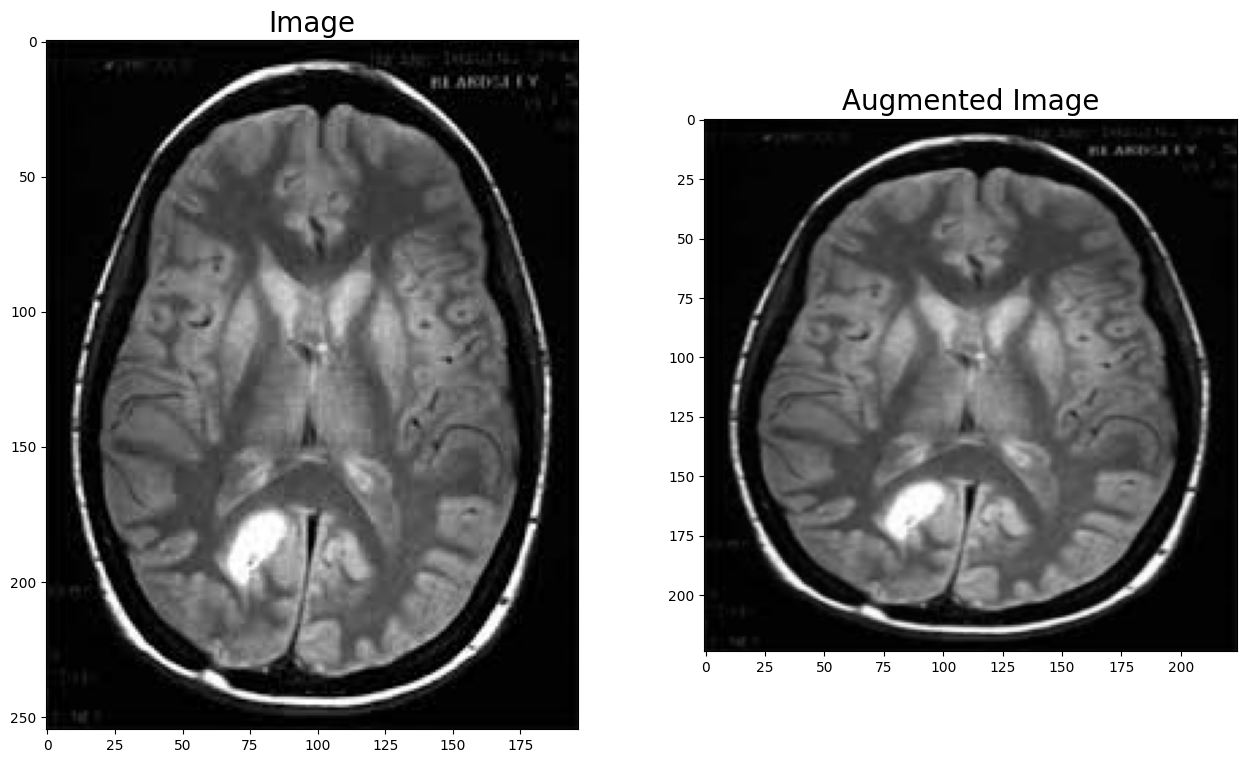

In [ ]:
# Visualization of augmented vs original image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 10))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# View Original Image
ax1.set_title('Image', fontsize=20)
ax1.imshow(aug_image, cmap='gray');

# View Augmented Image
ax2.set_title('Augmented Image', fontsize=20)
ax2.imshow(train_transforms(aug_image).permute(1, 2, 0), cmap='gray');

This dataset class BrainTumorDataset allows easy loading and preprocessing of brain tumor MRI images for training deep learning model. It encapsulates the image loading process and provides flexibility for applying transformations to the images as needed during training or evaluation.

This class encapsulates the logic for loading and preprocessing MRI image data, making it suitable for integration into a PyTorch-based deep learning pipeline for brain tumor classification tasks.

In [ ]:
# Class encapsulation
class BrainTumorMRIDataset(Dataset):
    def __init__(self, df:pd.DataFrame, transform=None) -> None:
        super().__init__()
  #  extracts the image paths and labels from the DataFrame and stores them as lists
        self.paths = df['image_path'].to_list()
        self.labels = df['label'].to_list()
        self.transform = transform

        self.classes = sorted(list(df['label'].unique()))
        self.class_to_idx = {cls_name: _ for _, cls_name in enumerate(self.classes)}
    # loads an image from the specified index in the dataset
    def load_image(self, index:int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path).convert('RGB')

    def __len__(self) -> int:
        return self.paths.__len__()

    def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:  # retrieves a sample from the dataset at the specified index
        image = self.load_image(index)
        class_name = self.labels[index]
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(image), class_idx
        else:
            return image, class_idx

These datasets below are essential components of the machine learning pipeline, facilitating data loading, preprocessing, and integration into training and evaluation loops. By using custom datasets, users can ensure consistency and flexibility in handling different subsets of data for various stages of model development and evaluation

In [ ]:
# Build training dataset
train_ds = BrainTumorMRIDataset(train_new_df, transform=train_transforms)

# Build validation dataset
val_ds = BrainTumorMRIDataset(val_df, transform=test_transforms)

# Build test dataset
test_ds = BrainTumorMRIDataset(test_df, transform=test_transforms)

In [ ]:
# Build train dataloader
train_loader = DataLoader(
    dataset=train_ds,
    batch_size=CFG.batch_size,
    num_workers=CFG.num_workers,
    shuffle=CFG.apply_shuffle
)

# Build validation dataloader
val_loader = DataLoader(
    dataset=val_ds,
    batch_size=CFG.batch_size,
    num_workers=CFG.num_workers,
    shuffle=False
)

# Build test dataloader
test_loader = DataLoader(
    dataset=test_ds,
    batch_size=CFG.batch_size,
    num_workers=CFG.num_workers,
    shuffle=False
)


In [ ]:
# Class definetion of the efficient model
class EfficientNetV2Model(nn.Module):
    def __init__(self, backbone_model, name='efficientnet-v2-large',
                 num_classes=CFG.num_classes, device=CFG.device):
        super(EfficientNetV2Model, self).__init__()

        self.backbone_model = backbone_model
        self.device = device
        self.num_classes = num_classes
        self.name = name

        classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(in_features=1280, out_features=256, bias=True),
            nn.GELU(),
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(in_features=256, out_features=num_classes, bias=False)
        ).to(device)

        self._set_classifier(classifier)

    def _set_classifier(self, classifier:nn.Module) -> None:
        self.backbone_model.classifier = classifier

    def forward(self, image):
        return self.backbone_model(image)

Model Architecture

This is a convolutional neural network architecture that is known for its efficiency in terms of parameter size and computational cost while maintaining high performance. It is an improved version of the original EfficientNet architecture, incorporating advancements in neural network design principles.

EfficientNetV2 is chosen for its efficiency in terms of computational resources and parameter size. This is particularly important for resource-constrained environments or when dealing with large datasets. ( as the pervious intent model kept crashing on my PC)
Despite its efficiency, EfficientNetV2 maintains high performance in various computer vision tasks, including image classification. Its architectural advancements make it well-suited for capturing complex patterns and features in medical imaging data, such as brain tumor MRI images.

In [ ]:
def get_effiecientnetv2_model(
    device: torch.device=CFG.num_classes) -> nn.Module:
    # Set the manual seeds
    torch.manual_seed(CFG.seed)
    torch.cuda.manual_seed(CFG.seed)

    # Get model weights
    model_weights = (
        torchvision
        .models
        .EfficientNet_V2_L_Weights
        .DEFAULT
    )

    # Get model and push to device
    model = (
        torchvision.models.efficientnet_v2_l(
            weights=model_weights
        )
    ).to(device)

    # Freeze Model Parameters
    for param in model.features.parameters():
        param.requires_grad = False

    return model

In [ ]:
# Get EfficientNet v2 model
backbone_model = get_effiecientnetv2_model(CFG.device)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth
100%|██████████| 455M/455M [00:06<00:00, 77.2MB/s]


In [ ]:
efficientnetv2_params = {
    'backbone_model'    : backbone_model,
    'name'              : 'efficientnet-v2-large',
    'device'            : CFG.device
}

# Generate Model
efficientnet_model = EfficientNetV2Model(**efficientnetv2_params)

# If using GPU T4 x2 setup, use this:
if CFG.num_devices > 1:
    efficientnet_model = nn.DataParallel(efficientnet_model)

In [ ]:
# View model summary
summary(
    model=efficientnet_model,
    input_size=(CFG.batch_size, CFG.channels, CFG.width, CFG.height),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
EfficientNetV2Model (EfficientNetV2Model)                         [32, 3, 224, 224]    [32, 4]              --                   Partial
├─EfficientNet (backbone_model)                                   [32, 3, 224, 224]    [32, 4]              --                   Partial
│    └─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    │    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   (928)                False
│    │    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 32, 112, 112]   (37,120)             False
│    │    └─Sequential (2)                                        [32, 32, 112, 112]   [32, 64, 56, 56]     (1,032,320)          False
│    │    └─Sequential (3)                     

Layers:

Convolutional Layers: The backbone of the EfficientNetV2 model consists of multiple convolutional layers. These layers perform feature extraction by applying convolutional filters to the input images, capturing hierarchical patterns and features at different spatial scales.
Pooling Layers: EfficientNetV2 employs various pooling operations, such as max pooling, to downsample feature maps and reduce their spatial dimensions while preserving important information.
Fully Connected Layers: At the end of the network, there are fully connected layers that perform classification based on the extracted features. These layers map the high-dimensional feature representations to the number of output classes.
Activation Functions:
ReLU (Rectified Linear Unit): ReLU is used as the activation function in most of the convolutional layers. It introduces non-linearity to the model, allowing it to learn complex patterns in the data.
Softmax: Softmax activation is applied to the output layer to convert the raw scores into probabilities for each class. It ensures that the predicted probabilities sum up to one and provides a probabilistic interpretation of the model's predictions.
Learning Rate (lr): The learning rate determines the step size at which the model parameters are updated during training. A higher learning rate  lead to faster convergence. A lower learning rate (0.001) resulted in slower training but more stable convergence.
Batch Size: The batch size determines the number of samples processed in each iteration during training. It affected the model's ability to generalize and the speed of convergence. A larger batch size can lead to faster training but may require more memory.
Number of Epochs: The number of epochs specifies how many times the entire dataset is passed forward and backward through the model during training. It affects the model's ability to converge to the optimal solution.
Optimizer: The choice of optimizer, such as Adam or SGD, and its associated hyperparameters (e.g., momentum, weight decay) can significantly impact training performance and convergence speed.

In [ ]:
# Define Loss Function
loss_fn = nn.CrossEntropyLoss(
    label_smoothing=0.1
)

# Define Optimizer
optimizer = torch.optim.AdamW(
    efficientnet_model.parameters(),
    lr=CFG.lr
)

In [ ]:
def execute_epoch(
    model:torch.nn.Module,
    dataloader:torch.utils.data.DataLoader,
    optimizer:torch.optim.Optimizer,
    loss_fn:torch.nn.Module,
    device:torch.device) -> Tuple[float, float]:

    # Set model into training mode
    model.train()

    # Initialize train loss & accuracy
    train_loss, train_acc = 0, 0

    # Execute training loop over train dataloader
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        # Load data onto target device
        X, y = X.to(device), y.to(device)

        # Feed-forward and compute metrics
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Reset Gradients & Backpropagate Loss
        optimizer.zero_grad()
        loss.backward()

        # Update Model Gradients
        optimizer.step()

        # Compute Batch Metrics
        predicted_class = torch.argmax(
            torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (predicted_class == y).sum().item() / len(y_pred)

    # Compute Step Metrics
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

In [ ]:
def evaluate(
    model:torch.nn.Module,
    dataloader:torch.utils.data.DataLoader,
    loss_fn:torch.nn.Module,
    device:torch.device) -> Tuple[float, float]:

    # Set model into eval mode
    model.eval()

    # Initialize eval loss & accuracy
    eval_loss, eval_acc = 0, 0

    # Active inferene context manager
    with torch.inference_mode():
        # Execute eval loop over dataloader
        for batch, (X, y) in enumerate(dataloader):
            # Load data onto target device
            X, y = X.to(device), y.to(device)

            # Feed-forward and compute metrics
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            eval_loss += loss.item()

            # Compute Batch Metrics
            predicted_class = torch.argmax(
                torch.softmax(y_pred, dim=1), dim=1)
            eval_acc += (predicted_class == y).sum().item() / len(y_pred)

    # Compute Step Metrics
    eval_loss = eval_loss / len(dataloader)
    eval_acc = eval_acc / len(dataloader)

    return eval_loss, eval_acc

In [ ]:
def train(
    model:torch.nn.Module,
    train_dataloader:torch.utils.data.DataLoader,
    eval_dataloader:torch.utils.data.DataLoader,
    optimizer:torch.optim.Optimizer,
    loss_fn:torch.nn.Module,
    epochs:int,
    device:torch.device) -> Dict[str, List]:

    # Initialize training session
    session = {
        'loss'          : [],
        'accuracy'      : [],
        'eval_loss'     : [],
        'eval_accuaracy': []
    }

    # Training loop
    for epoch in tqdm(range(epochs)):
        # Execute Epoch
        print(f'\nEpoch {epoch + 1}/{epochs}')
        train_loss, train_acc = execute_epoch(
            model,
            train_dataloader,
            optimizer,
            loss_fn,
            device
        )

        # Evaluate Model
        eval_loss, eval_acc = evaluate(
            model,
            eval_dataloader,
            loss_fn,
            device
        )

        # Log Epoch Metrics
        print(f'loss: {train_loss:.4f} - acc: {train_acc:.4f} - eval_loss: {eval_loss:.4f} - eval_acc: {eval_acc:.4f}')

        # Record Epoch Metrics
        session['loss'].append(train_loss)
        session['accuracy'].append(train_acc)
        session['eval_loss'].append(eval_loss)
        session['eval_accuaracy'].append(eval_acc)

    # Return Session Metrics
    return session

In [ ]:
# Traning session
def train(
    model:torch.nn.Module,
    train_dataloader:torch.utils.data.DataLoader,
    eval_dataloader:torch.utils.data.DataLoader,
    optimizer:torch.optim.Optimizer,
    loss_fn:torch.nn.Module,
    epochs:int,
    device:torch.device) -> Dict[str, List]:

    # Initialize training session
    session = {
        'loss'          : [],
        'accuracy'      : [],
        'eval_loss'     : [],
        'eval_accuaracy': []
    }

    # Training loop
    for epoch in tqdm(range(epochs)):
        # Execute Epoch
        print(f'\nEpoch {epoch + 1}/{epochs}')
        train_loss, train_acc = execute_epoch(
            model,
            train_dataloader,
            optimizer,
            loss_fn,
            device
        )

        # Evaluate Model
        eval_loss, eval_acc = evaluate(
            model,
            eval_dataloader,
            loss_fn,
            device
        )

        # Log Epoch Metrics
        print(f'loss: {train_loss:.4f} - acc: {train_acc:.4f} - eval_loss: {eval_loss:.4f} - eval_acc: {eval_acc:.4f}')

        # Record Epoch Metrics
        session['loss'].append(train_loss)
        session['accuracy'].append(train_acc)
        session['eval_loss'].append(eval_loss)
        session['eval_accuaracy'].append(eval_acc)

    # Return Session Metrics
    return session

In [ ]:
def evaluate(
    model:torch.nn.Module,
    dataloader:torch.utils.data.DataLoader,
    loss_fn:torch.nn.Module,
    device:torch.device) -> Tuple[float, float]:

    # Set model into eval mode
    model.eval()

    # Initialize eval loss & accuracy
    eval_loss, eval_acc = 0, 0

    # Active inferene context manager
    with torch.inference_mode():
        # Execute eval loop over dataloader
        for batch, (X, y) in enumerate(dataloader):
            # Load data onto target device
            X, y = X.to(device), y.to(device)

            # Feed-forward and compute metrics
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            eval_loss += loss.item()

            # Compute Batch Metrics
            predicted_class = torch.argmax(
                torch.softmax(y_pred, dim=1), dim=1)
            eval_acc += (predicted_class == y).sum().item() / len(y_pred)

    # Compute Step Metrics
    eval_loss = eval_loss / len(dataloader)
    eval_acc = eval_acc / len(dataloader)

    return eval_loss, eval_acc

In [ ]:
# Train the model
print('Training EfficientNet Model')
print(f'Train on {len(train_new_df)} samples, validate on {len(val_df)} samples.')
print('----------------------------------')

efficientnet_session_config = {
    'model'               : efficientnet_model,
    'train_dataloader'    : train_loader,
    'eval_dataloader'     : val_loader,
    'optimizer'           : optimizer,
    'loss_fn'             : loss_fn,
    'epochs'              : CFG.epochs,
    'device'              : CFG.device
}

efficientnet_session_history = train(**efficientnet_session_config)


Training EfficientNet Model
Train on 90 samples, validate on 23 samples.
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 1/10


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


loss: 1.0387 - acc: 0.4872 - eval_loss: 1.0388 - eval_acc: 0.6087

Epoch 2/10


  0%|          | 0/3 [00:00<?, ?it/s]

loss: 0.8258 - acc: 0.7067 - eval_loss: 0.9680 - eval_acc: 0.4783

Epoch 3/10


  0%|          | 0/3 [00:00<?, ?it/s]

loss: 0.7153 - acc: 0.8574 - eval_loss: 0.8340 - eval_acc: 0.7391

Epoch 4/10


  0%|          | 0/3 [00:00<?, ?it/s]

loss: 0.6121 - acc: 0.8958 - eval_loss: 0.7827 - eval_acc: 0.7826

Epoch 5/10


  0%|          | 0/3 [00:00<?, ?it/s]

loss: 0.5871 - acc: 0.9199 - eval_loss: 0.8274 - eval_acc: 0.6522

Epoch 6/10


  0%|          | 0/3 [00:00<?, ?it/s]

loss: 0.5402 - acc: 0.8814 - eval_loss: 0.8271 - eval_acc: 0.6522

Epoch 7/10


  0%|          | 0/3 [00:00<?, ?it/s]

loss: 0.4802 - acc: 0.9663 - eval_loss: 0.6856 - eval_acc: 0.8696

Epoch 8/10


  0%|          | 0/3 [00:00<?, ?it/s]

loss: 0.5539 - acc: 0.9199 - eval_loss: 0.6673 - eval_acc: 0.8696

Epoch 9/10


  0%|          | 0/3 [00:00<?, ?it/s]

loss: 0.4777 - acc: 0.9792 - eval_loss: 0.7571 - eval_acc: 0.6957

Epoch 10/10


  0%|          | 0/3 [00:00<?, ?it/s]

loss: 0.5047 - acc: 0.9351 - eval_loss: 0.6550 - eval_acc: 0.7826


In [ ]:
# model prediction
def predict(
    model:nn.Module,
    sample_loader:torch.utils.data.DataLoader,
    device:torch.device) -> np.ndarray:

    # Set model into eval mode
    model.eval()

    predictions = []

    # Active inferene context manager
    with torch.inference_mode():
        # Execute eval loop over dataloader
        for batch, (X, y) in enumerate(tqdm(sample_loader)):
            # Load data onto target device
            X, y = X.to(device), y.to(device)

            # Feed-forward and compute metrics
            y_pred = model(X)

            # Compute Batch Metrics
            predicted_probs = torch.softmax(y_pred, dim=1).cpu().numpy()

            # Record prediction
            predictions.append(predicted_probs)

    return np.vstack(predictions)


In [ ]:
# Generate test sample probabilities
efficientnet_test_probs = predict(efficientnet_model, test_loader, CFG.device)

  0%|          | 0/4 [00:00<?, ?it/s]

Testing my Model on a new dataset

In [ ]:
import os
# Define a Python class CFG
class CFG:
    # Determine the device to be used for computations: 'cuda' if GPU is available, otherwise 'cpu'
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Get the number of available GPU devices
    num_devices = torch.cuda.device_count()

    # Get the number of CPU cores
    num_workers = os.cpu_count()

    # Define the number of classes in the classification task
    num_classes = 4

    # Define the number of epochs for training
    epochs = 10

    # Define the batch size for training data. If multiple GPUs are available, increase the batch size accordingly
    batch_size = (
        32 if torch.cuda.device_count() < 2
        else (32 * torch.cuda.device_count())
    )

    # Define the learning rate for the optimizer
    lr = 0.001

    # Specify whether to apply shuffle to the training data during each epoch
    apply_shuffle = True

    # Set a random seed for reproducibility
    seed = 768

    # Define the height and width of input images
    height = 224
    width = 224

    # Define the number of channels in input images (e.g., 3 for RGB images)
    channels = 3

    # Define the image size as a tuple (height, width, channels)
    image_size = (224, 224, 3)

    # Define paths
    dataset_path = '/content/drive/MyDrive/NEW DATA'
    train_path = '/content/drive/MyDrive/NEW DATA/Train'
    test_path = '/content/drive/MyDrive/NEW DATA/Test'

In [ ]:
from torchvision.datasets import ImageFolder

# Define a transformation pipeline to preprocess the images
data_transform = transforms.Compose([
    transforms.Resize((CFG.height, CFG.width)),  # Resize images to a fixed size
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

# Load the data using ImageFolder
dataset = ImageFolder(root=CFG.dataset_path, transform=data_transform)

In [ ]:
from torch.utils.data import random_split

# Define the sizes of the training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset into training and validation sets
train_set, val_set = random_split(dataset, [train_size, val_size])

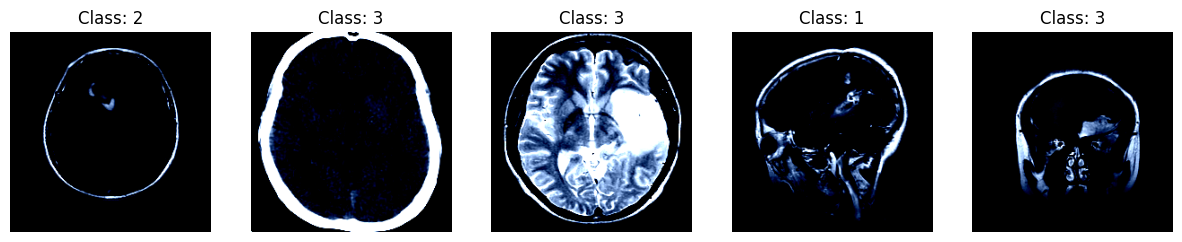

In [ ]:
# Define a function to display sample images from the dataset
def show_samples(dataset):
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        image, label = dataset[i]
        axes[i].imshow(image.permute(1, 2, 0))
        axes[i].set_title(f'Class: {label}')
        axes[i].axis('off')
    plt.show()

# Display sample images from the training set
show_samples(train_set)

In [ ]:
from torchvision import transforms

# Define data augmentation transformations
augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.RandomResizedCrop(size=(CFG.height, CFG.width), scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
])

# Combine data augmentation with previous transformations
train_transform = transforms.Compose([
    augmentation_transform,
    data_transform
])

In [ ]:
# Convert EfficientNet history dict to DataFrame
efficientnet_session_history_df = pd.DataFrame(efficientnet_session_history)
efficientnet_session_history_df

,loss,accuracy,eval_loss,eval_accuaracy
0,1.038654,0.487179,1.038758,0.608696
1,0.825784,0.706731,0.967964,0.478261
2,0.715313,0.857372,0.834040,0.739130
3,0.612093,0.895833,0.782718,0.782609
4,0.587076,0.919872,0.827391,0.652174
5,0.540198,0.881410,0.827111,0.652174
6,0.480245,0.966346,0.685596,0.869565
7,0.553905,0.919872,0.667331,0.869565
8,0.477661,0.979167,0.757137,0.695652
9,0.504739,0.935096,0.654980,0.782609


In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12):
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Set plot size
    plt.figure(figsize=figsize)

    # Create confusion matrix heatmap
    disp = sns.heatmap(
        cm, annot=True, cmap='Greens',
        annot_kws={"size": text_size}, fmt='g',
        linewidths=0.5, linecolor='black', clip_on=False,
        xticklabels=classes, yticklabels=classes)

    # Set title and axis labels
    disp.set_title('Confusion Matrix', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=20)
    disp.set_ylabel('True Label', fontsize=20)
    plt.yticks(rotation=0)

    # Plot confusion matrix
    plt.show()

    return

In [ ]:
test_labels = [*map(test_ds.class_to_idx.get, test_ds.labels)]

In [ ]:
# Generate test sample probabilities
efficientnet_test_probs = predict(efficientnet_model, test_loader, CFG.device)

  0%|          | 0/4 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
# Generate test sample preditions
efficientnet_test_preds = np.argmax(efficientnet_test_probs, axis=1)

In [ ]:
print(
    classification_report(
        test_labels,
        efficientnet_test_preds,
        target_names=test_ds.classes
))

              precision    recall  f1-score   support

    Negative       0.07      0.08      0.08        49
    Positive       0.22      0.20      0.21        65

    accuracy                           0.15       114
   macro avg       0.15      0.14      0.14       114
weighted avg       0.16      0.15      0.15       114



In [ ]:
print(
    classification_report(
        test_labels,
        efficientnet_test_preds,
        target_names=test_ds.classes
))

              precision    recall  f1-score   support

    Negative       0.07      0.08      0.08        49
    Positive       0.22      0.20      0.21        65

    accuracy                           0.15       114
   macro avg       0.15      0.14      0.14       114
weighted avg       0.16      0.15      0.15       114



Reference